In [1]:
!conda install scikit-learn -y

Retrieving notices: done
Channels:
 - defaults
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.1.1
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [2]:
import math
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.constants import pi,g
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

file = "panguweather.nc"
ds = xr.open_dataset(file)
#print(ds)

FileNotFoundError: [Errno 2] No such file or directory: '/home/neo/geostrophic-balance-meteo497/panguweather.nc'

In [3]:
# Grid spacing distance using Haversine formula
# Takes lat/lon in degrees and returns distance in meters
def grid_distance(lat1, lat2, lon1, lon2):
    r = 6371
    lat1, lat2, lon1, lon2 = map(math.radians, [lat1, lat2, lon1, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a),math.sqrt(1-a))
    distance = r * c
    return distance * 1000


In [4]:
# Calculating ug and vg vectors of wind
def calculate_wind(lat, lat_next, lat_prev, lon, lon_next, lon_prev, pressure, time):
    geopotential_prev_x = ds["GP_P0_L100_GLL0"].sel(
        lat_0 = lat, lon_0 = lon_prev, lv_ISBL0 = pressure, forecast_time0 = time).item()
    geostrophic_height_prev_x = geopotential_prev_x / g

    geopotential_next_x = ds["GP_P0_L100_GLL0"].sel(
        lat_0 = lat, lon_0 = lon_next, lv_ISBL0 = pressure, forecast_time0 = time).item()
    geostrophic_height_next_x = geopotential_next_x / g

    geopotential_prev_y = ds["GP_P0_L100_GLL0"].sel(
        lat_0 = lat_prev, lon_0 = lon, lv_ISBL0 = pressure, forecast_time0 = time).item()
    geostrophic_height_prev_y = geopotential_prev_y / g

    geopotential_next_y = ds["GP_P0_L100_GLL0"].sel(
        lat_0 = lat_next, lon_0 = lon, lv_ISBL0 = pressure, forecast_time0 = time).item()
    geostrophic_height_next_y = geopotential_next_y / g


    omega = (2*pi)/86164.1
    f = 2 * omega * math.sin( math.radians(lat) )

    dx = grid_distance(lat1 = lat, lat2 = lat, lon1 = lon_prev, lon2 = lon_next)
    dy = grid_distance(lat1 = lat_prev, lat2 = lat_next, lon1 = lon, lon2 = lon)

    dzdx = (geostrophic_height_next_x - geostrophic_height_prev_x) / (dx)
    dzdy = (geostrophic_height_next_y - geostrophic_height_prev_y) / (dy)

    calculated_ug = (-g / f) * (dzdy)
    calculated_vg = (g / f) * (dzdx)

    return (calculated_ug, calculated_vg)

In [ ]:
# Creates real wind data structure
latitudes = ds["lat_0"].values[1:-1]
longitudes = ds["lon_0"].values[1:-1]

pressure = ds["lv_ISBL0"][7].item() # 50,000

lat_indices = range(1, len(latitudes), 10)  # e.g., 1, 11, 21, ... 711
lon_indices = range(1, len(longitudes), 10)  # e.g., 1, 11, 21, ... 1431
ug = ds["UGRD_P0_L100_GLL0"].sel(lv_ISBL0=pressure)
vg = ds["VGRD_P0_L100_GLL0"].sel(lv_ISBL0=pressure)

ug_sample = ug.isel(lat_0=lat_indices, lon_0=lon_indices)
vg_sample = vg.isel(lat_0=lat_indices, lon_0=lon_indices)

ug_array = np.full((ds["forecast_time0"].size, len(lat_indices), len(lon_indices)), np.nan, dtype=np.float32)
vg_array = np.full((ds["forecast_time0"].size, len(lat_indices), len(lon_indices)), np.nan, dtype=np.float32)

real_wind_ds = xr.Dataset(
    {
        "ug": (["forecast_time0", "lat_0", "lon_0"], ug_sample.data),
        "vg": (["forecast_time0", "lat_0", "lon_0"], vg_sample.data)
    },
    coords={
        "forecast_time0": ds["forecast_time0"],
        "lat_0": latitudes[lat_indices],
        "lon_0": longitudes[lon_indices],
        "lv_ISBL0": pressure
    }
)
real_wind_ds["wind_speed"] = np.sqrt(real_wind_ds["ug"]**2 + real_wind_ds["vg"]**2)

In [ ]:
# Sampled wind calculation over one time slice
# Over latitudes
time_length = ds["forecast_time0"].size
for time_index in range(time_length):
    time = ds["forecast_time0"].isel(forecast_time0 = time_index)
    for i, lat_index in enumerate(lat_indices):
        # Over longitudes
        for j, lon_index in enumerate(lon_indices):

            lat = ds["lat_0"][lat_index].item()

            lat_next = ds["lat_0"][lat_index+1].item()
            lat_prev = ds["lat_0"][lat_index-1].item()
            lon = ds["lon_0"][lon_index].item()
            lon_next = ds["lon_0"][lon_index+1].item()
            lon_prev = ds["lon_0"][lon_index-1].item()

            u,v = calculate_wind(lat, lat_next, lat_prev, lon, lon_next, lon_prev, pressure, time)

            ug_array[time_index,i,j] = u
            vg_array[time_index, i,j] = v


KeyboardInterrupt: 

In [7]:
time = ds["forecast_time0"].isel(forecast_time0 = 0)
short_calculated_wind_ds = xr.Dataset(
    {
        "ug": (["forecast_time0", "lat_0", "lon_0"], ug_array),
        "vg": (["forecast_time0", "lat_0", "lon_0"], vg_array)
    },
    coords={
        "lat_0": latitudes[lat_indices],
        "lon_0": longitudes[lon_indices],
        "lv_ISBL0": pressure,
        "forecast_time0": ds["forecast_time0"]
    }
)

short_calculated_wind_ds["wind_speed"] = np.sqrt(short_calculated_wind_ds["ug"]**2 + short_calculated_wind_ds["vg"]**2)

In [ ]:
short_calculated_wind_ds.to_netcdf("short_calculated_wind_ds.nc")
real_wind_ds.to_netcdf("real_wind_ds.nc")

In [8]:
short_calculated_wind_ds = xr.open_dataset("short_calculated_wind_ds.nc")

/tmp/ipykernel_155584/3705471678.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  short_calculated_wind_ds = xr.open_dataset("short_calculated_wind_ds.nc")


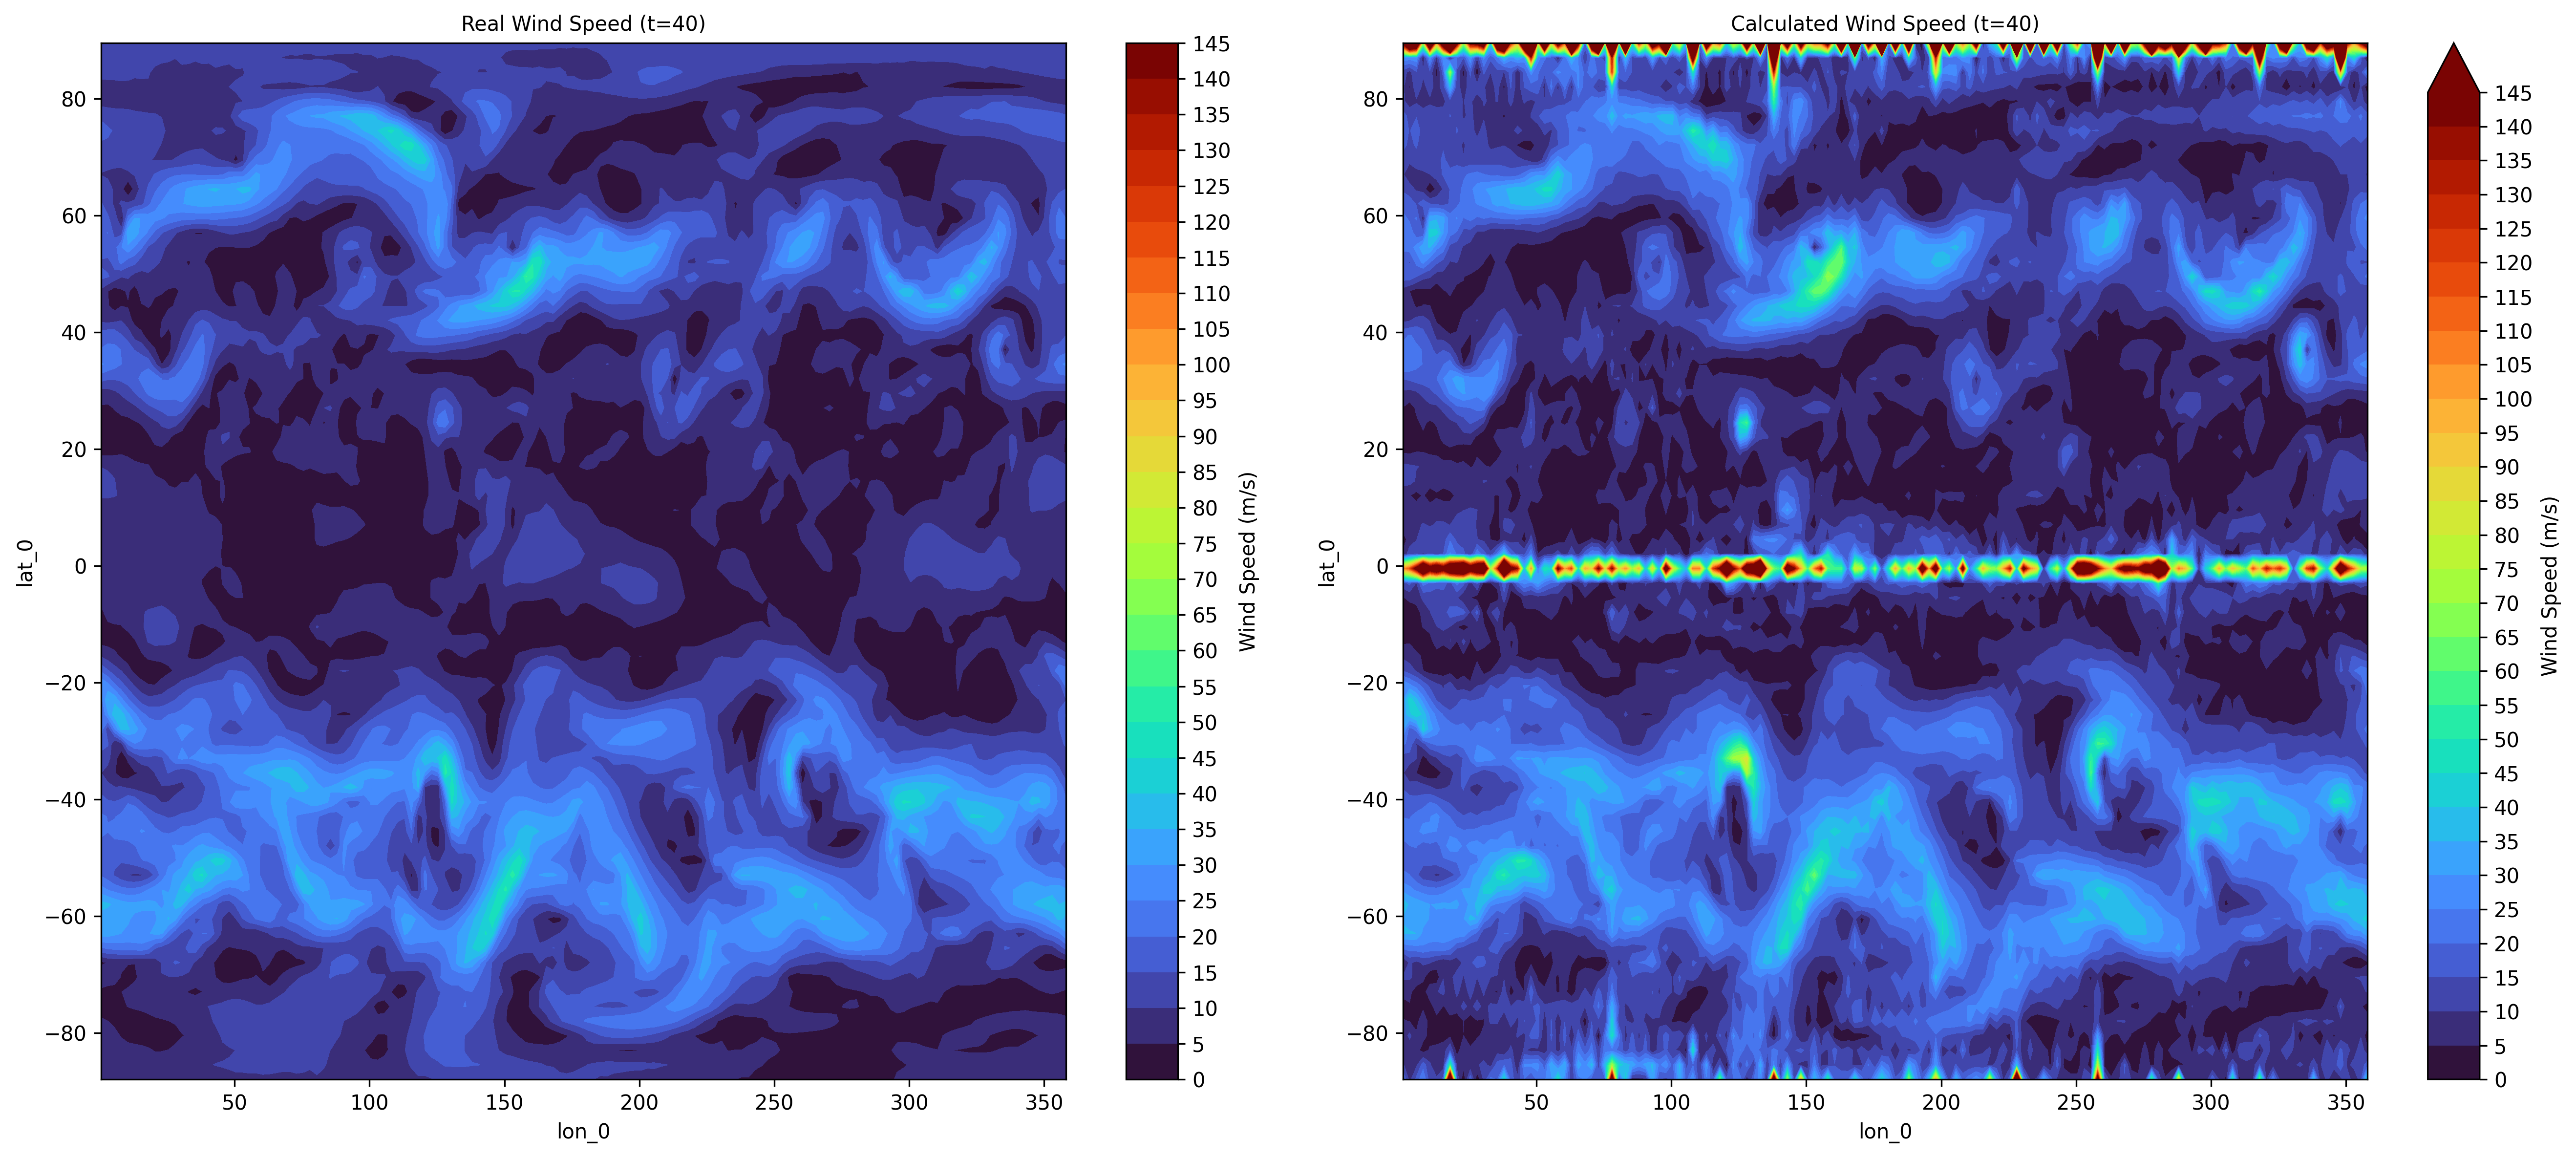

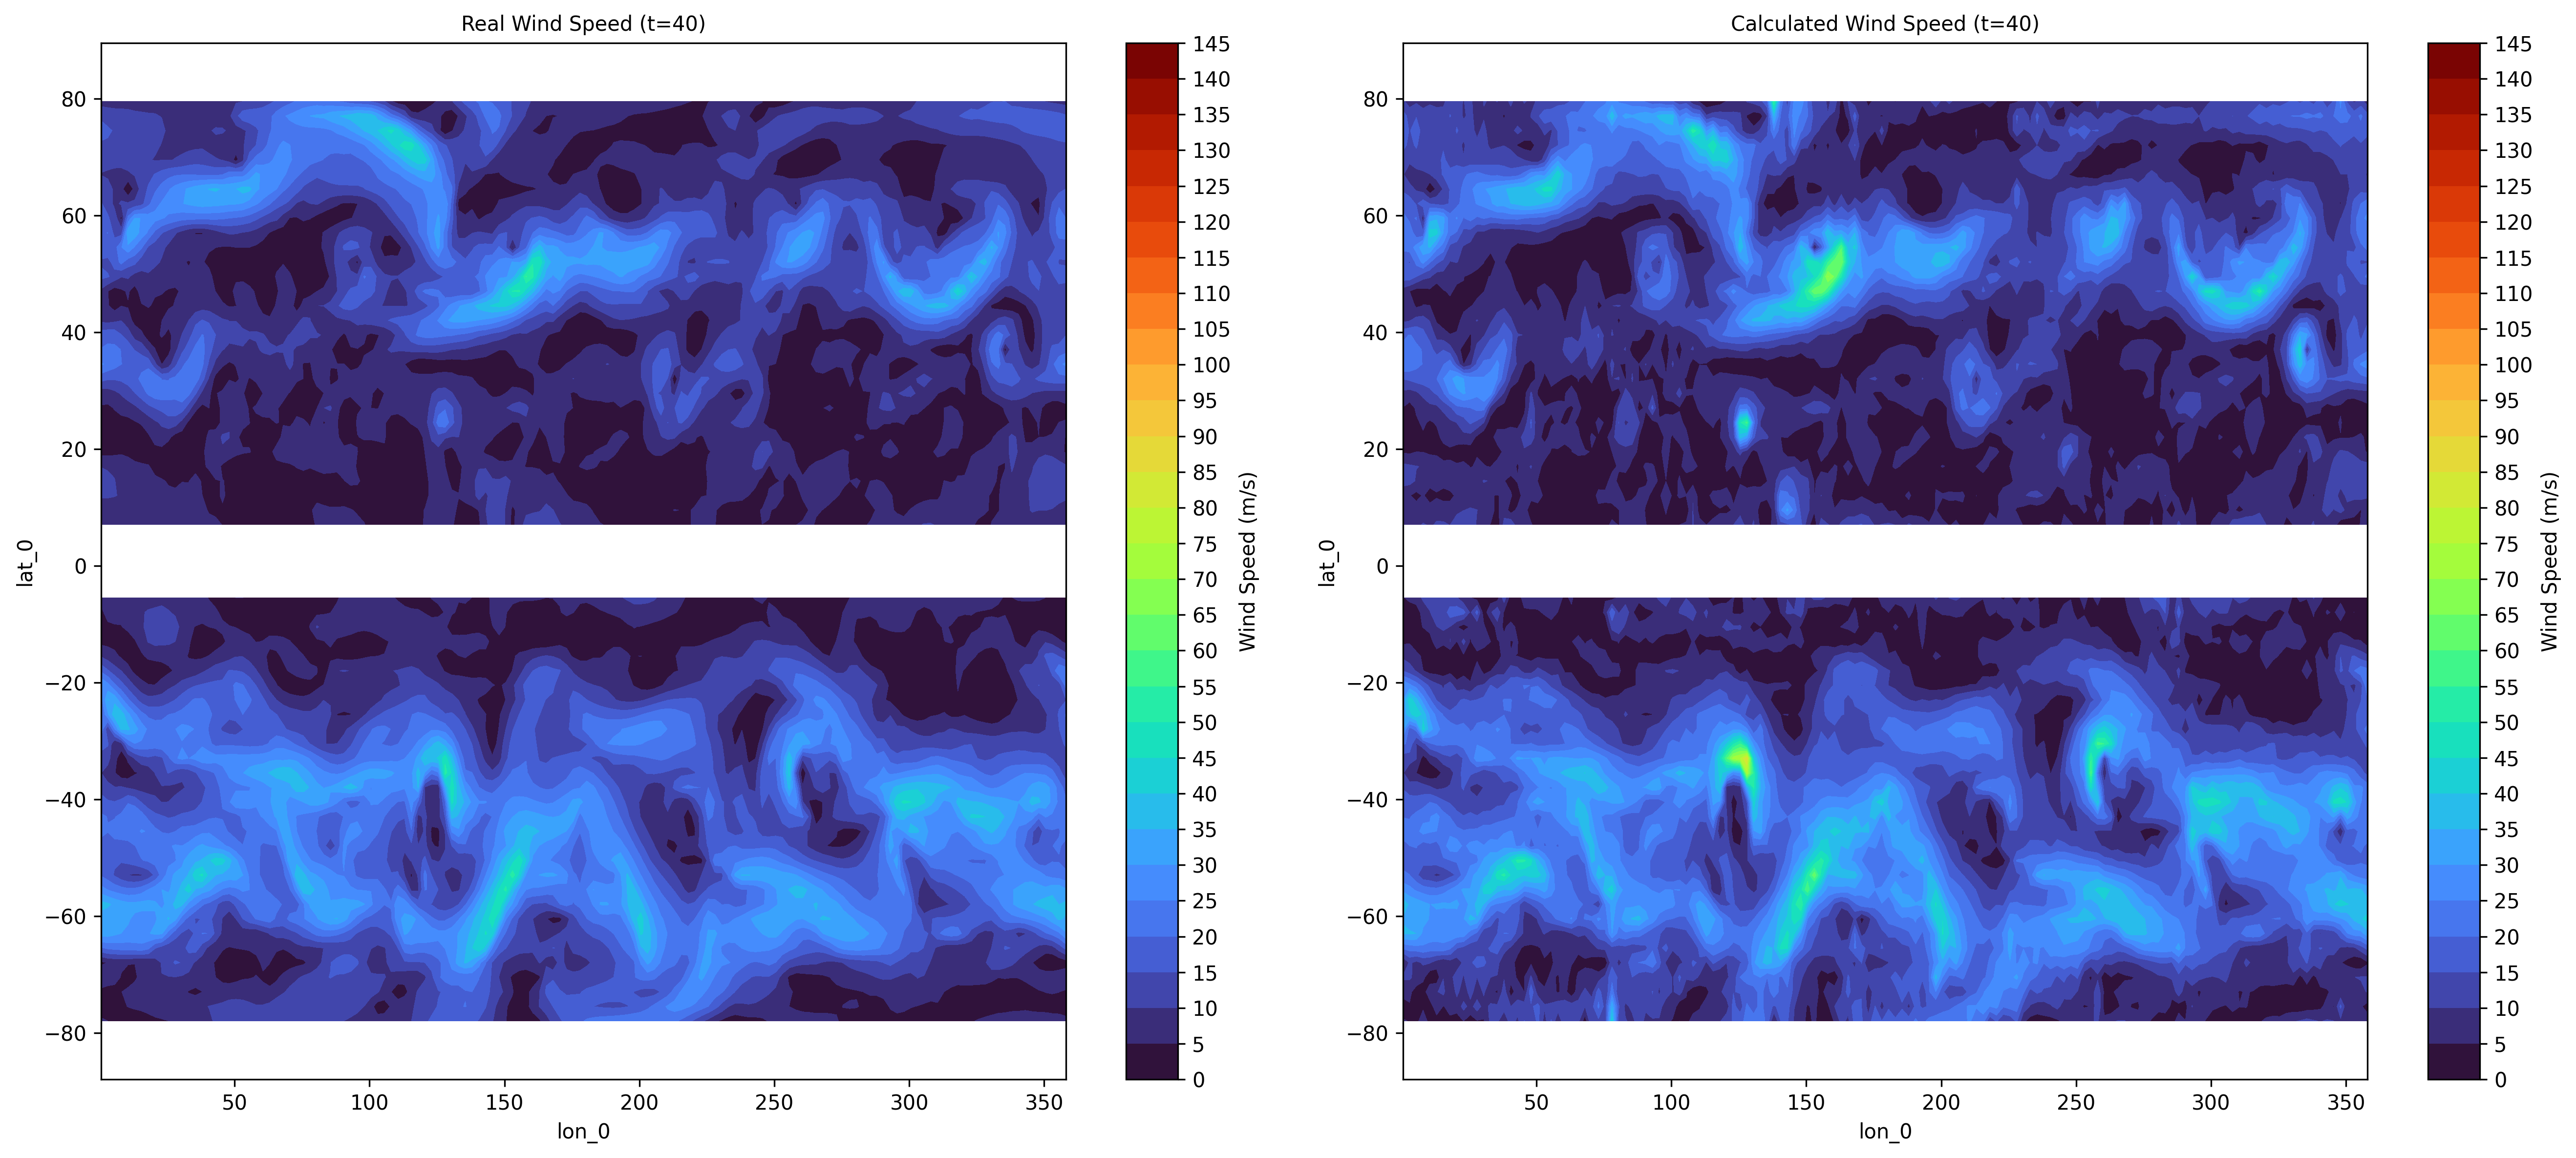

In [57]:
# Makes a countour map of wind speeds

# def plot_wind(wind_speeds, title = "Geostrophic Wind"):
#     levels = list(range(0, 150, 5))
#     cmap = plt.get_cmap("turbo", len(levels) - 1)
#     norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
#     plt.figure(figsize=(12, 8))
#     wind_speeds.plot.contourf( x="lon_0", y="lat_0", cmap=cmap, norm=norm, levels=levels, cbar_kwargs={"label": "Wind Speed (m/s)","ticks": levels})
#     plt.title(title)
#     plt.tight_layout()
#     plt.show()

def plot_wind_side_by_side(real_speed, calc_speed, time_index):
    levels = list(range(0, 150, 5))
    cmap = plt.get_cmap("turbo", len(levels) - 1)
    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

    fig, axs = plt.subplots(1, 2, figsize=(18, 8), dpi=300)

    real_speed.plot.contourf(
        ax=axs[0],
        x="lon_0", y="lat_0",
        cmap=cmap, norm=norm, levels=levels,
        cbar_kwargs={"label": "Wind Speed (m/s)", "ticks": levels}
    )
    axs[0].set_title(f"Real Wind Speed (t={time_index})", fontsize=10)

    calc_speed.plot.contourf(
        ax=axs[1],
        x="lon_0", y="lat_0",
        cmap=cmap, norm=norm, levels=levels,
        cbar_kwargs={"label": "Wind Speed (m/s)", "ticks": levels}
    )
    axs[1].set_title(f"Calculated Wind Speed (t={time_index})", fontsize=10)

    plt.tight_layout()
    plt.show()

time_index = 40
real_speed = real_wind_ds["wind_speed"].isel(forecast_time0=time_index)
calc_speed = short_calculated_wind_ds["wind_speed"].isel(forecast_time0=time_index)
plot_wind_side_by_side(real_speed, calc_speed, time_index)

latitude_conditional = (
    ((short_calculated_wind_ds["lat_0"] > -5) & (short_calculated_wind_ds["lat_0"] < 5)) |
    (short_calculated_wind_ds["lat_0"] > 80) |
    (short_calculated_wind_ds["lat_0"] < -80)
)

reduced_short_calculated_wind_ds = short_calculated_wind_ds.where(~latitude_conditional)
reduced_real_wind_ds = real_wind_ds.where(~latitude_conditional)
real_speed = reduced_real_wind_ds["wind_speed"].isel(forecast_time0=time_index)
calc_speed = reduced_short_calculated_wind_ds["wind_speed"].isel(forecast_time0=time_index)
plot_wind_side_by_side(real_speed, calc_speed, time_index)


In [ ]:
def correlationMSE(time, real_ds, calc_ds):
    real_winds_flattened = real_ds["wind_speed"].isel(forecast_time0=time).values.flatten()
    real_winds_flattened = real_winds_flattened[~np.isnan(real_winds_flattened)]
    calc_winds_flattened = calc_ds["wind_speed"].isel(forecast_time0=time).values.flatten()
    calc_winds_flattened = calc_winds_flattened[~np.isnan(calc_winds_flattened)]

    correlation, p = pearsonr(real_winds_flattened, calc_winds_flattened)
    rootMSE = np.sqrt(mean_squared_error(real_winds_flattened, calc_winds_flattened))
    return correlation, p, rootMSE

correlations = []
rootMSEs = []
for i in range(ds["forecast_time0"].size):
    correlation, p, rootMSE = correlationMSE(i, short_calculated_wind_ds, real_wind_ds)
    correlations.append(correlation)
    rootMSEs.append(rootMSE)

reduced_correlations = []
reduced_rootMSEs = []
for i in range(ds["forecast_time0"].size):
    correlation, p, rootMSE = correlationMSE(i, reduced_short_calculated_wind_ds, reduced_real_wind_ds)
    reduced_correlations.append(correlation)
    reduced_rootMSEs.append(rootMSE)


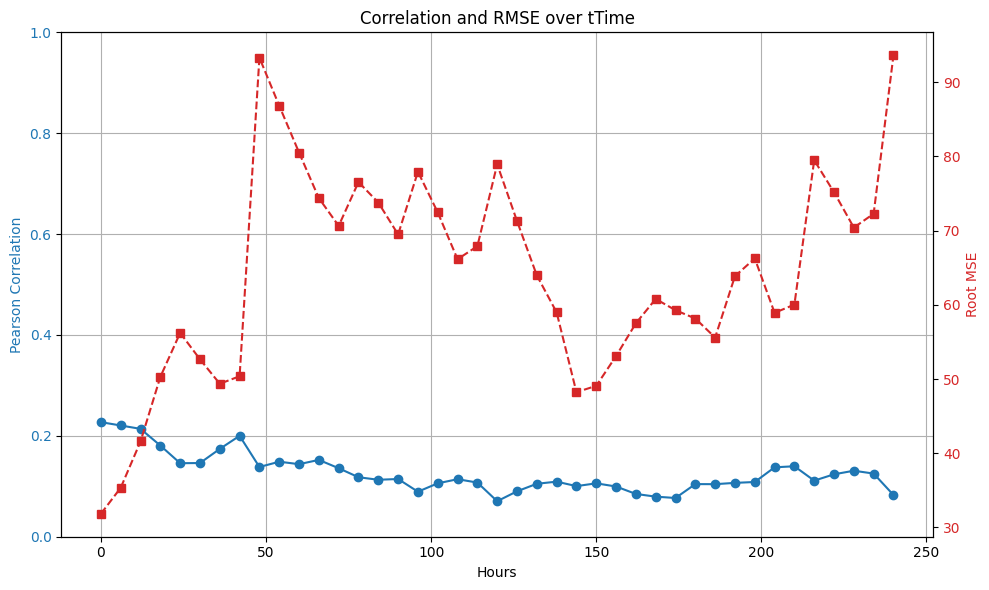

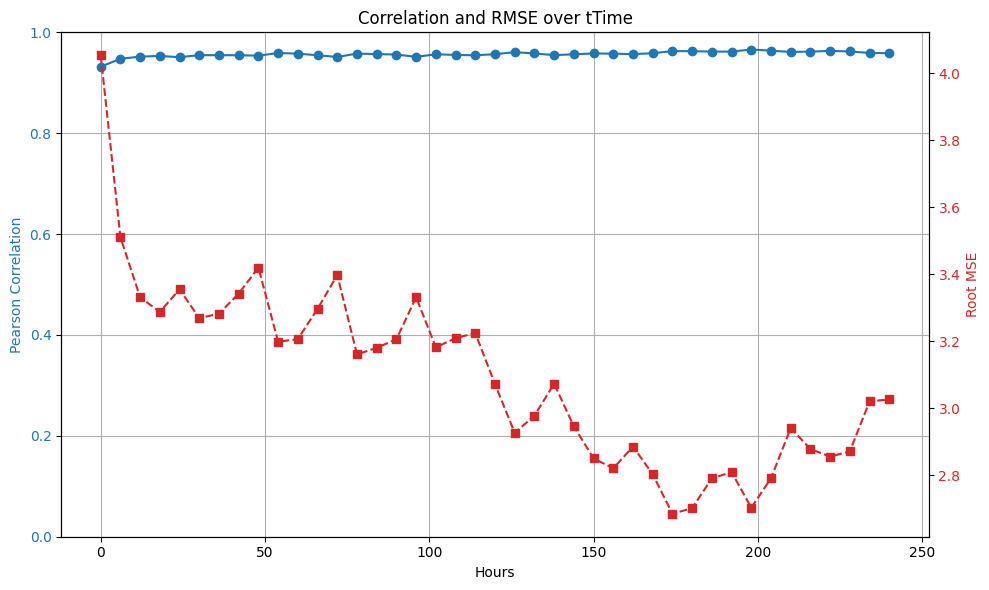

In [ ]:
hours = [i * 6 for i in range(ds["forecast_time0"].size)]
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel("Hours")
ax1.set_ylabel("Pearson Correlation", color=color)
ax1.plot(hours, correlations, marker='o', linestyle='-', color=color, label='Correlation')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Root MSE", color=color)
ax2.plot(hours, rootMSEs, marker='s', linestyle='--', color=color, label='RMSE')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Correlation and RMSE over time")
fig.tight_layout()
plt.show()



hours = [i * 6 for i in range(ds["forecast_time0"].size)]
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel("Hours")
ax1.set_ylabel("Pearson Correlation", color=color)
ax1.plot(hours, reduced_correlations, marker='o', linestyle='-', color=color, label='Correlation')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Root MSE", color=color)
ax2.plot(hours, reduced_rootMSEs, marker='s', linestyle='--', color=color, label='RMSE')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Correlation and RMSE over time")
fig.tight_layout()
plt.show()